# How to compute LSD profiles

:::{warning}
Work in progress
:::

In this tutorial, we demonstrate the calculation of LSD profiles. 

In [6]:
import specpolFlow as pol
import matplotlib.pyplot as plt

In [4]:
mask_file = '../GetStarted/OneObservationFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask'
obs_file = '../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_1.s'

## Calculating a LSD profile "on-the-fly"

Modified line mask, removed 64 too closely spaced lines
Average observed spec velocity spacing: 1.810029 km/s
using a 222 point profile with 1.810000 km/s pixels
mean mask depth 0.101386 wl 494.081 Lande 1.179956 (from 1039 lines)
mean mask norm weightI 0.506930 weightV 0.480710
saving model spectrum to  ...
I reduced chi2 246.2941 (chi2 25234058.65 constraints 102677 dof 222)
 Rescaling error bars by: 15.693759
V reduced chi2 1.1163 (chi2 114370.84 constraints 102677 dof 222)
 Rescaling error bars by: 1.056552
 removing profile continuum pol: -5.2971e-06 +/- 1.2152e-08 (avg err 1.1009e-04)
N1 reduced chi2 1.1078 (chi2 113495.91 constraints 102677 dof 222)
 Rescaling error bars by: 1.052503
 removing profile continuum pol: -6.4597e-06 +/- 1.2059e-08 (avg err 1.0967e-04)
line range estimate -18.999999999999773 47.97000000000031 km/s
V in line reduced chi^2 54.735240 (chi2 2025.203891) 
 detect prob 1.000000 (fap 0.000000e+00)
 Detection! V (fap 0.000000e+00)
 V outside line reduced chi^

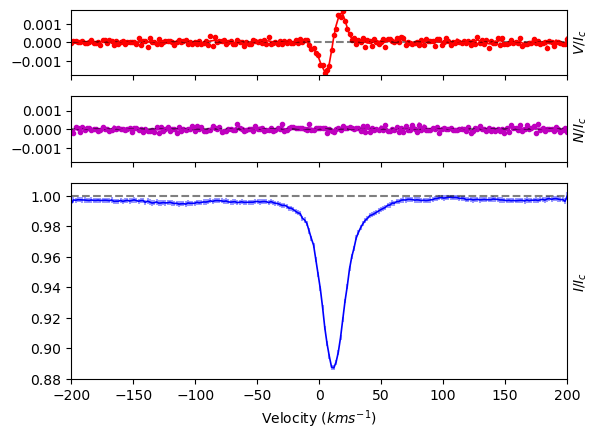

In [5]:
lsd, mod = pol.run_lsdpy(obs=obs_file, mask=mask_file)

:::{note}
The `normWave` value needs to be given in nanometers
:::

In [ ]:
lsd, mod = pol.run_lsdpy(obs=obs_file, mask=mask_file, velStart=-100, velEnd=100,
                         normLande=1.2, normDepth=0.2, normWave=500)

## Having a look at the model spectrum

The function also returns a Spectrum object [Add link to API] that contains the LSD model (that is, the LSD profile convolved with the line mask -- or to be more precises)

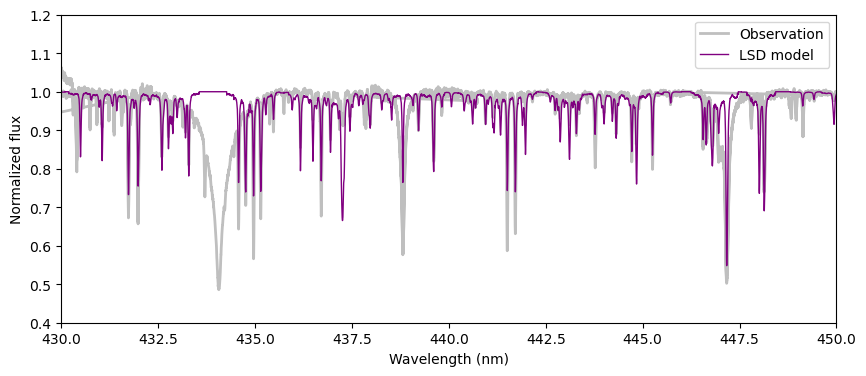

In [17]:
spec = pol.read_spectrum(obs_file)

fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(spec.wl, spec.specI, lw=2, c='0.75', label='Observation')
ax.set_xlim(430,450)
ax.set_ylim(0.4,1.2)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Normalized flux')

ax.plot(mod.wl, mod.specI, c='purple', lw=1, label='LSD model')

ax.legend(loc=0)

## Using the keywords for batch calculation/saving